# CSE 204 Lab 11: Unsupervised Learning - Clustering

J.B. Scoggins, Jesse Read

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jbscoggi/teaching/blob/master/Polytechnique/CSE204/Lab11_answers.ipynb) 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jbscoggi/teaching/master?filepath=Polytechnique%2FCSE204%2FLab11_answers.ipynb)

## Introduction

In this lab, you will implement two unsupervised learning algorithms cluster data points based on similarity criteria: k-means, and spectral k-means.  While libraries such as scikit-learn provide facilities that implement these algorithms, they are simple enough for you to implement with numpy alone.  Before beginning, import the required packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

### Datasets

Throughout this lab, you will use 3 simple datasets to test your algorithms.  Run the code below to visualize each dataset. As you can see, the first dataset consists of 4 gaussian-distributed clusters of points with equal variance.  The second represents two clusters, one stretched vertically, and one horizontally.  Finally, the last dataset represents 3 clusters distributed in rings.  For convenience, the three datasets are placed in a list called `datasets`.  In the rest of the lab, you will be asked to implement 2 clustering algorithms and run on them on these datasets.

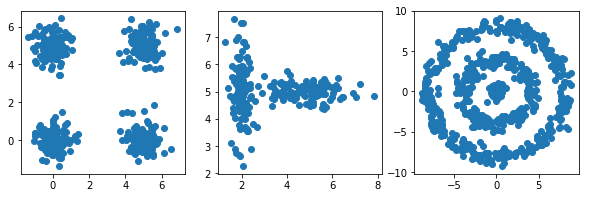

In [3]:
# Create a data set
N = 120

data1 = np.random.normal((0,0), (0.5,0.5) ,size=(N,2))
data1 = np.append(data1, np.random.normal((5,0), (0.5,0.5), size=(N,2)), axis=0)
data1 = np.append(data1, np.random.normal((0,5), (0.5,0.5), size=(N,2)), axis=0)
data1 = np.append(data1, np.random.normal((5,5), (0.5,0.5), size=(N,2)), axis=0)

data2 = np.random.normal((2,5), (0.25, 1), size=(N,2))
data2 = np.append(data2, np.random.normal((5,5), (1, 0.25), size=(N,2)), axis=0)

radii = np.random.normal(0,0.5,size=(N,1))
radii = np.append(radii, np.random.normal(4,0.5,size=(2*N,1)), axis=0)
radii = np.append(radii, np.random.normal(8,0.5,size=(3*N,1)), axis=0)
angles = np.random.uniform(size=(6*N,1))*2.0*np.pi
data3 = np.hstack([radii*np.cos(angles), radii*np.sin(angles)])

datasets = [data1, data2, data3]

fig, axes = plt.subplots(1,len(datasets), figsize=(10,3))
for i,data in enumerate(datasets):
    axes[i].scatter(data[:,0], data[:,1])

## Part 1: The k-Means Algorithm

k-means is one of the simplest unsupervised learning algorithms that solves the well known clustering problem. The algorithm defines an iterative process, where the following two steps take part at each iteration:
1. take each instance belonging to the dataset and assign it to the nearest centroid, and
2. re-calculate the centroids of each of the k clusters. 
Thus, the k centroids change their location step by step until no more changes are done.

More formally, suppose that we are given a dataset $X = \{x_1, x_2, \dots , x_n\}$, where each $x_i \in \mathbb{R}^d$. The goal of the k-means algorithm is to group the data into $k$ cohesive clusters, where $k$ is an input parameter of the algorithm. **Your task is to implement this algorithm**. Algorithm 1 gives the pseudocode.

___
### Algorithm 1: k-means

**Input**: Dataset $\mathbf{X} = \{\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n\}$, where each $\mathbf{x}_i \in \mathbb{R}^d$ and parameter $k$ <br>
**Output**: Clusters $\mathbf{C}_1, \mathbf{C}_2, \ldots, \mathbf{C}_k$ (i.e., cluster assignments of each instance $C = \{c_1, c_2, \ldots, c_n\}$)

1. Initialize cluster centroids ${\boldsymbol\mu}_1, \boldsymbol{\mu}_2, \ldots, \boldsymbol{\mu}_k$ by choosing $k$ instances of $\mathbf{X}$ randomly

**Repeat:**
2. Assign each instance $\mathbf{x}_i \in \mathbf{X}$ to the closest centroid, i.e., $c_j = \text{argmin}_j \|\mathbf{x}_i - \boldsymbol{\mu}_j\|$
3. Re-compute the centroids $\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \ldots, \boldsymbol{\mu}_k$ of each cluster based on $\boldsymbol{\mu}_j = (\sum_{\mathbf{x} \in \mathbf{C}_j} \mathbf{x})/|\mathbf{C}_j|$, where $\mathbf{C}_j, j=1, \ldots, k$ the $j$-th cluster and  $|\mathbf{C}_j|$ the size of the $j$-th cluster

**until** Centroids do not change (convergence)
___

In the algorithm above, $k$ is a parameter of the algorithm and corresponds to the number of clusters we want to find; the cluster centroids $\mu_j$ represent our current guesses for the positions of the centers of the clusters. To initialize the cluster centroids (in step 1 of the algorithm), we could choose $k$ training examples randomly, and set the cluster centroids to be equal to the values of these $k$ examples. Of course, other initialization methods are also possible, such as the [kmeans++ technique](https://en.wikipedia.org/wiki/K-means%2B%2B). To find the closest centroid, a distance (or similarity) function should be defined, and typically the Euclidean distance is used.

In [61]:
def euclidean_distance(X1, X2):
    """
        Distance Function
        -----------------
        Computes the Euclidean distance between two arrays of points.
    
        Returns: a 2D n by m array where entry [i,k] returns the distance 
                from the i-th point in X1 to the k-th point in X2.
    """
    # TODO
    distance = np.zeros((X1.shape[0], X2.shape[0]))
    for i in range(X1.shape[0]):
        for k in range(X2.shape[0]):
            distance[i,k] = np.sum(np.square(X1[i,:]-X2[k,:]))
    return np.sqrt(distance)
    # END TODO

In [62]:
def k_means(X, k):
    """
    k Means
    --------
    
    
    Parameters
    ----------
    
    X : an n-by-d matrix of inputs
    k : the number of clusters to find
    
    
    Algorithm:
    ----------
    
    0. Implement the euclidean distance function
    1. Initialize (choose) the centroids
    2. Implement a `while` loop such that, while centroids have not changed since the last iteration:
        - compute the distances of all points to each centroid
        - label each point (associate it with) the nearest centroid
        - recompute the centroids (i.e., average of points belonging to each centroid)
    
    Return
    ------
    
    z : the labels, associating each point with a cluster (see note)
    iters : the number of iterations carried out until convergence
    
    ****
    Note: Two possibilities for z:
         1. As a 1D vector of labels of length n
            z[i] = 1 : the i-th instance is assigned to cluster 1 (2nd cluster/k)
         2. As a n-by-k array of labels
            z[i] = [0,1,0] : the i-th instance is assigned to cluster 1 (2nd cluster/3)
    
        IMPORTANT: If you use approach 1. use c=labels in scatter-plotting code
                   If you use approach 2. use np.argmax(labels, axis=1) in scatter-plotting code
    ***
    
    """
    # TODO
    n,d = X.shape
    
    # Initialize (choose) the centroids
    indices = np.random.choice(n,k,replace=False)
    means = X[indices,:]
    
    z = np.zeros(n)
    z_last = np.ones(n)
    
    # Iterate until convergence
    iters = 0
    while (z != z_last).any():
        z_last = z
        iters += 1
        
        # Compute distances
        distance = euclidean_distance(X, means)
        
        # Label the points
        z = np.argmin(distance,axis=1)

        # Compute new averages
        for j in range(k):
            means[j] = np.mean(X[z==j],axis=0)
            
    # Calculate cost (this is only used for a later task)
    E = sum(np.min(distance,axis=1))   
    
    # END TODO
    return z, iters

To test your implementation, run the following code which will plot the 3 datasets, trying differente values of $k$. It will display the number of iterations until convergence (along with $k$ in the title).

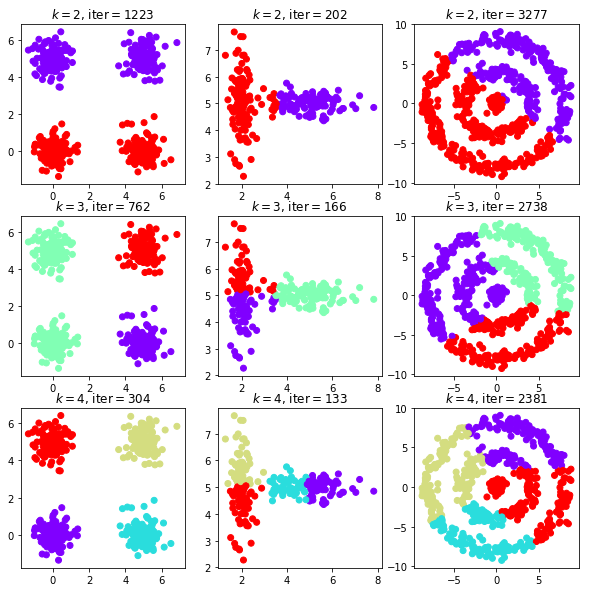

In [63]:
fig, axes = plt.subplots(3,len(datasets),figsize=(10,10))
for i,k in enumerate([2,3,4]):
    for j,data in enumerate(datasets):
        labels, iters = k_means(data,k)
        axes[i,j].scatter(data[:,0], data[:,1], c=labels, cmap='rainbow')
        axes[i,j].set_title('$k=%d$, iter$=%d$' % (k,iters))

Based on its notion of similarity, the problem of $k$-means clustering can be reduced to the problem of finding appropriate centroids. This, in turn, can be expressed as the task of minimizing the following objective function:
$$
     E(k) = \sum_{j=1}^{k} \sum_{\mathbf{x}_i \in \mathbf{C}_j}\| \mathbf{x}_i - \boldsymbol{\mu}_j \|.
$$

Thus, minimizing the above function is to determine suitable centroids $\mathbf{\mu}_j$ such that, if the data is partitioned into corresponding clusters $\mathbf{C}_j$, distances between data points and their closest cluster centroid become as small as possible.

The convergence of the $k$-means algorithm is highly dependent on the initialization of the centroids. It may converge to a local minimum of the objective function above. One way to overcome this problem is by executing the algorithm several times, with different initializations of the centroids. 

Another issue is how to determine the number of clusters ($k$) of the dataset. Intuitively, increasing $k$ without penalty, will always reduce the amount of error in the resulting clustering, to the extreme case of zero error if each data point is considered its own cluster (i.e., when $k=n$). One such method is known as the *elbow rule*. The idea is to examine  and compare the error given above for a number of cluster solutions.  In general, as the number of clusters increases, the SSE should decrease because clusters are, by definition, smaller. A plot of the SSE against a series of sequential cluster levels (i.e., different values) can be helpful here. That is, an appropriate cluster solution could be defined as the one where the reduction in SSE slows dramatically. This produces an "elbow" in the plot of SSE against the different values of $k$. 

Bonus Task: Implement the elbow rule to find an appropriate value for $k$, as follows:

1. Run k-means clustering for values of $k=1,\ldots,10$. 
2. For each $k$, calculate the total intra-cluster error ($E(k)$, given above)
3. Plot the curve of $E(k)$ vs $k$.
4. Try to identify the location of a bend (elbow) in the plot -- this is generally considered as an indicator of the appropriate number of clusters.

Text(0.5,0,'$k$')

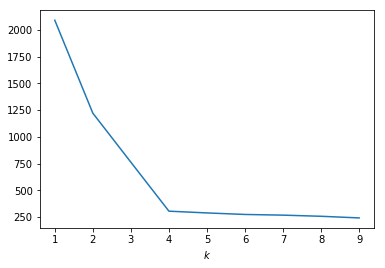

In [64]:
# TODO
# This is a little bit hacky: replace iters with E in the return 
# of the k-means solution, before running this code
costs = []
k_list = range(1,10)
for k in k_list:
    E = k_means(datasets[0],k)[1]
    costs.append(E)
fig = figure()
plot(k_list,costs)
xlabel('$k$')
# Note the 'elbow' at k=4
# END TODO

## Part II: Spectral Clustering

Spectral clustering techniques make use of the *spectrum* (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. The similarity matrix is provided as an input and consists of a quantitative assessment of the relative similarity of each pair of points in the dataset.

Given a set of data points $\mathbf{x}_1, \ldots ,\mathbf{x}_n, \forall \mathbf{x}_i \in \mathbb{R}^d$ and some notion of similarity $s_{ij}$ between all pairs of data points $\mathbf{x}_i$ and $\mathbf{x}_j$, the intuitive goal of clustering is to divide the data points into several groups such that points in the same group are similar and points in different groups are dissimilar to each other. If we do not have more information than similarities between data points, a nice way of representing the data is in form of the similarity graph $G = (V,E)$. Each vertex $v_i$ in this graph represents a data point
$\mathbf{x}_i$. Two vertices are connected if the similarity $s_{ij}$ between the corresponding data points $\mathbf{x}_i$ and $\mathbf{x}_j$ is positive or larger than a certain threshold, and the edge is weighted by $s_{ij}$. The problem of clustering
can now be reformulated using the similarity graph: we want to find a partition of the graph such that the edges between different groups have very low weights (which means that points in different clusters are dissimilar from each other) and the edges within a group have high weights (which means that points within the same cluster are similar to each other).

### Creating the similarity graph

There are several popular constructions to transform a given set $\mathbf{x}_1, \ldots , \mathbf{x}_m, \forall \mathbf{x}_i \in \mathbb{R}^n$ of data points with pairwise
similarities $s_{ij}$ or pairwise distances $d_{ij}$ into a graph. When constructing similarity graphs the goal is to model the local neighborhood relationships between the data points. We will use the approach of the $k$-Nearest Neighbors graph. Here the goal is to connect vertex $\mathbf{x}_i$ with vertex $\mathbf{x}_j$ if $\mathbf{x}_j$ is among the $k$-nearest neighbors of $\mathbf{x}_i$. This definition leads to a directed graph, as the neighborhood relationship is not symmetric. The most common way to deal with this, is to simply ignore the directions of the edges; that is, we connect $\mathbf{x}_i$ and $\mathbf{x}_j$ with an undirected edge if $\mathbf{x}_i$ is among the $k$-nearest neighbors of $\mathbf{x}_j$ or if $\mathbf{x}_j$ is among the $k$-nearest neighbors of $\mathbf{x}_i$. The resulting graph is what is usually called the $k$-nearest neighbors graph.

### The algorithm

The pseudocode of the spectral clustering algorithm is given as follows. In spectral clustering, the data is projected into a lower-dimensional space (the spectral/eigenvector domain) where they are easily separable, say using $k$-means. 

Given dataset $\mathbf{X}=\{ \mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_m}\}$, where  each $\mathbf{x}_i \in \mathbb{R}^n$ and parameter $k$:

1. Construct the similarity graph $G$ as described above. Let 
    * $\mathbf{W}$ be the adjacency matrix of this graph.
    * $\mathbf{D}$ be the diagonal degree matrix of graph $G$, ie $\mathbf{D}_{ii} = \sum_j \mathbf{W}_{ij}$ and $\mathbf{D}_{ij} = 0$ for $i \neq j$.
2. Compute the Laplacian matrix $\mathbf{L} = \mathbf{D} - \mathbf{W}$. 
3. Apply eigenvalue decomposition to the Laplacian matrix $\mathbf{L}$ 
4. Select the eigenvectors that correspond to $k$ smallest eigenvalues. Let $\mathbf{U}$ contain these corresponding eigenvectors in its columns.
5. Apply $k$-means to $\mathbf{U}$ (as if the rows were instances), thus finding clusters $\mathbf{C}_1, \mathbf{C}_2, \ldots, \mathbf{C}_k$.

**Your Task** Implement the algorithm. *Hint*: Use the distance function and the $k$-means implementation you wrote in Task 1.

*Python hints:* to find the `k` nearest neighbors of $x_i$, you can use the function `np.argsort` with the array that stores `d(x_i, x_j)`. You can use `eigenvalues, eigenvectors = np.linalg.eig(L)` to obtain the eigenvalues and eigenvectors of a (square) matrix `L`.


In [65]:
def spectral_k_means(X, k, k_nn):
    '''
        Spectral Clustering
        -------------------
        
        Parameters
        ----------
        
        X : the data
        k : the number of clusters to find
        k_nn : the number of k nearest-neighbours to consider in the graph construction
        
        Returns
        -------
        
        The same numbers as your k-means method above
    '''
    #TODO
    closest_neighbors = np.argsort(euclidean_distance(X,X),axis=1)[:,:k_nn]
    W = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        W[i,closest_neighbors[i,:]] = 1
        W[closest_neighbors[i,:],i] = 1
    
    D = np.diag(np.sum(W, axis=0))
    L = D - W
    Lambda, U = np.linalg.eig(L)
    idx = Lambda.argsort()
    U = U[:,idx[:k]]
    #END TODO
    return k_means(U, k)
    

To test your implementation, run the following code which will plot the 3 datasets, trying different values of $k$. It will display the number of iterations (done by $k$-means) until convergence (along with $k$ in the title).

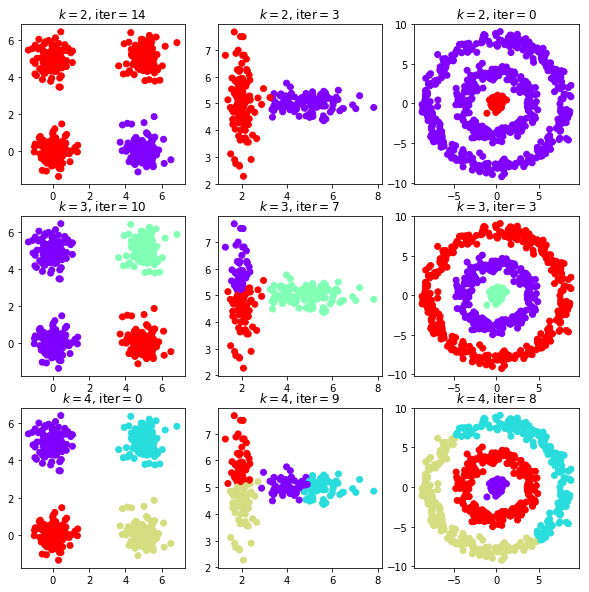

In [66]:
fig, axes = plt.subplots(3,len(datasets), figsize=(10,10))
for i,k in enumerate([2,3,4]):
    for j,data in enumerate(datasets):
        labels, iters = spectral_k_means(data,k,10)
        axes[i,j].scatter(data[:,0], data[:,1], c=labels, cmap='rainbow')
        axes[i,j].set_title('$k=%d$, iter$=%d$' % (k,iters))
        

## Task 3: Gaussian Mixture Model (Bonus Task)

Suppose you observe and measure a number of beetles, recording their length in centimeters -- given below in the array `x`. You are curious to investigate if you have recorded more than one species. In fact you believe you are studying two distinct species. You decide to use Gaussian Mixture Models on the data to elaborate on this hypothesis and gain further insight into the beetle population. 

**Task: Implement Gaussian Mixture Models**

Note: Plotting code is provided. 
Hint: See the lecture slides regarding pseudocode and outline. Note that you may obtain slightly different results each time you run the algorithm.

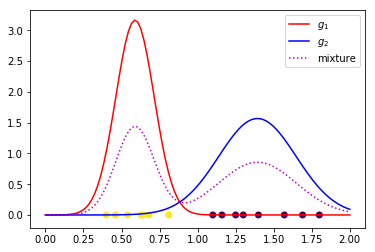

In [13]:
# beetle lengths
x = np.array([1.57, 1.16, 1.30, 0.46, 0.40, 0.63,  0.68,  0.54,  0.64,  0.81, 1.80, 1.40,  1.10,  1.25, 1.69], dtype=float)
# no. of beetles
N = len(x)
# no. species
K = 2

# responsibilities (beetle i pertains r[i,k]-much to species k)
r = np.random.random((N,K))
# normalized
r[:,1] = np.ones(N) - r[:,0]

## evaluate (Gaussian) pdf 'g' at point 'x' under mean m, sd s
def g(x, m = 0.0, s = 1.0):
    return np.exp(-(x - m)**2/(2*s**2)) * 1/np.sqrt(2*s**2*np.pi)

# Initialize parameters to random values
m = np.random.rand(K) * 2
s = np.random.rand(K)

# Initialize weights (prior probabilities) aka pi
w = np.ones(K)/N

# EM ALGORITHM
T = 100 # max iterations
for t in range(0,T):
    # TODO

    # E: expected membership | params
    for n in range(0,N):
        for k in range(0,K):
            r[n,k] = w[k] * g(x[n],m[k],s[k])
        Z = sum(r[n,:])
        r[n,:] = r[n,:] / Z
            
    # M: maximize likelihood of this membership with params
    for k in range(0,K):
        Z_k = sum(r[:,k])
        w[k] = 1.0/N * sum(r[:,k])
        m[k] = np.dot(r[:,k],x) / Z_k
        s[k] = np.sqrt(sum(r[:,k] / Z_k * (m[k] - x)**2)) 
        
# END TODO

fig = plt.figure()
xx = np.linspace(0, 2, num=100)      # points to plot
plt.plot(xx,g(xx,m[0],s[0]),'r-',label="$g_1$")
plt.plot(xx,g(xx,m[1],s[1]),'b-',label="$g_2$")
plt.plot(xx,w[0]*g(xx,m[0],s[0])+w[1]*g(xx,m[1],s[1]),'m:',label="mixture")
c = np.sum(m)/2.
y = (x < c)*1 
plt.legend()
plt.scatter(x,np.zeros(N), c=y, label="beetles")